## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [2]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [3]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [4]:
with open('./pickle/data.npy', 'rb') as f:
    X_trains= np.load(f)
    y_trains = np.load(f)
    TEST = np.load(f)

In [5]:
print(X_trains.shape)
print(y_trains.shape)
print(TEST.shape)

(2048, 28, 28, 3)
(2048, 10)
(20480, 28, 28, 3)


In [6]:
X_trains = X_trains.astype('float32') / 255.
TEST = TEST.astype('float32') / 255.

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose, Activation, Dropout,UpSampling2D, GlobalAveragePooling2D, Dense ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

### DenseNet

In [8]:
def Conv_block(x, filter_unit, activation='relu'):
    
    # 28x28x128
    x_l = Conv2D(filter_unit, (1,1), padding='same', kernel_initializer='he_normal')(x)
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    
    x_l = Conv2D(filter_unit, (3,3), strides=(2,2), padding='same', kernel_initializer='he_normal')(x_l)
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    
    x_l = Conv2D(filter_unit*4, (1,1), padding='same', kernel_initializer='he_normal')(x_l)
    x_l = BatchNormalization()(x_l)
    
    short = Conv2D(filter_unit*4, (1,1),  strides=(2,2), padding='same', kernel_initializer='he_normal')(x)
    short = BatchNormalization()(short)
    
    x = add([x_l, short])
    x = Activation(activation)(x)
    return x

def identity_block(x, filter_unit, activation='relu'):
    # 28x28x128
    x_l = Conv2D(filter_unit, (1,1), padding='same', kernel_initializer='he_normal')(x)
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    
    x_l = Conv2D(filter_unit, (3,3), padding='same', kernel_initializer='he_normal')(x_l)
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    
    x_l = Conv2D(filter_unit*4, (1,1), padding='same', kernel_initializer='he_normal')(x_l)
    x_l = BatchNormalization()(x_l)
    
    x = add([x, x_l])
    x = Activation(activation)(x)
    return x

def Dense_block(x, layers, filter_unit):
    for i in range(layers):
        x = identity_block(x, filter_unit)
    return x

def DenseNet(shape=(28,28,3), classes = 10, densenet_type='DenseNet-121'):
    inputs = Input(shape)
    base_filter_unit = 32
    
    x = Conv2D(base_filter_unit*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Conv_block(x, 32)
    x = Dense_block(x, layers_in_block[densenet_type][0], base_filter_unit)
    
    x = Conv_block(x, 64)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_filter_unit*2)
    
    x = Conv_block(x, 128)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_filter_unit*4)
    
    x = Conv_block(x, 256)
    x = Dense_block(x, layers_in_block[densenet_type][3], base_filter_unit*8)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(classes, kernel_initializer='he_normal')(x)
    outputs = Activation('softmax', dtype='float32')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name=densenet_type)
    return model

In [9]:
layers_in_block = {'DenseNet-121':[3, 4, 4, 4],
                   'DenseNet-169':[6, 12, 32, 32],
                   'DenseNet-201':[6, 12, 48, 32],
                   'DenseNet-265':[6, 12, 64, 48],
                   'myDenseNet':[8, 12, 16, 32]}

model = DenseNet()

model.summary()

Model: "DenseNet-121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [11]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=8, shuffle=True, random_state=SEED)
    
    epochs = 300
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.8, min_lr=0.00001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
Epoch 1/300
55/56 [============================>.] - ETA: 0s - loss: 2.9072 - accuracy: 0.1170
Epoch 00001: val_loss improved from inf to 86.68881, saving model to model1_best_0.h5
56/56 [==============================] - 3s 45ms/step - loss: 2.9072 - accuracy: 0.1177 - val_loss: 86.6888 - val_accuracy: 0.0820 - lr: 0.0010
Epoch 2/300
55/56 [============================>.] - ETA: 0s - loss: 2.5653 - accuracy: 0.1261
Epoch 00002: val_loss improved from 86.68881 to 3.65931, saving model to model1_best_0.h5
56/56 [==============================] - 2s 31ms/step - loss: 2.5658 - accuracy: 0.1272 - val_loss: 3.6593 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/300
55/56 [============================>.] - ETA: 0s - loss: 2.5516 - accuracy: 0.1284
Epoch 00003: val_loss improved from 3.65931 to 3.26270, saving model to model1_best_0.h5
56/56 [==============================] - 2s 31ms/step - loss: 2.5564 - accuracy: 0.1289 - val_loss: 3.26

Epoch 28/300
55/56 [============================>.] - ETA: 0s - loss: 1.6408 - accuracy: 0.4307
Epoch 00028: val_loss improved from 1.56379 to 1.56053, saving model to model1_best_0.h5
56/56 [==============================] - 2s 34ms/step - loss: 1.6357 - accuracy: 0.4330 - val_loss: 1.5605 - val_accuracy: 0.4727 - lr: 8.0000e-04
Epoch 29/300
55/56 [============================>.] - ETA: 0s - loss: 1.5669 - accuracy: 0.4580
Epoch 00029: val_loss improved from 1.56053 to 1.56030, saving model to model1_best_0.h5
56/56 [==============================] - 2s 34ms/step - loss: 1.5705 - accuracy: 0.4559 - val_loss: 1.5603 - val_accuracy: 0.4805 - lr: 8.0000e-04
Epoch 30/300
55/56 [============================>.] - ETA: 0s - loss: 1.5567 - accuracy: 0.4648
Epoch 00030: val_loss did not improve from 1.56030
56/56 [==============================] - 1s 24ms/step - loss: 1.5565 - accuracy: 0.4648 - val_loss: 1.9852 - val_accuracy: 0.3828 - lr: 8.0000e-04
Epoch 31/300
55/56 [======================

55/56 [============================>.] - ETA: 0s - loss: 1.0833 - accuracy: 0.6392
Epoch 00055: val_loss did not improve from 1.01792
56/56 [==============================] - 1s 24ms/step - loss: 1.0889 - accuracy: 0.6367 - val_loss: 1.6249 - val_accuracy: 0.5352 - lr: 5.1200e-04
Epoch 56/300
54/56 [===========================>..] - ETA: 0s - loss: 1.0841 - accuracy: 0.6366
Epoch 00056: val_loss did not improve from 1.01792
56/56 [==============================] - 1s 25ms/step - loss: 1.0779 - accuracy: 0.6378 - val_loss: 1.9371 - val_accuracy: 0.5273 - lr: 5.1200e-04
Epoch 57/300
55/56 [============================>.] - ETA: 0s - loss: 1.0282 - accuracy: 0.6545
Epoch 00057: val_loss did not improve from 1.01792
56/56 [==============================] - 1s 24ms/step - loss: 1.0242 - accuracy: 0.6557 - val_loss: 1.1701 - val_accuracy: 0.6250 - lr: 4.0960e-04
Epoch 58/300
56/56 [==============================] - ETA: 0s - loss: 1.0219 - accuracy: 0.6479
Epoch 00058: val_loss did not impro

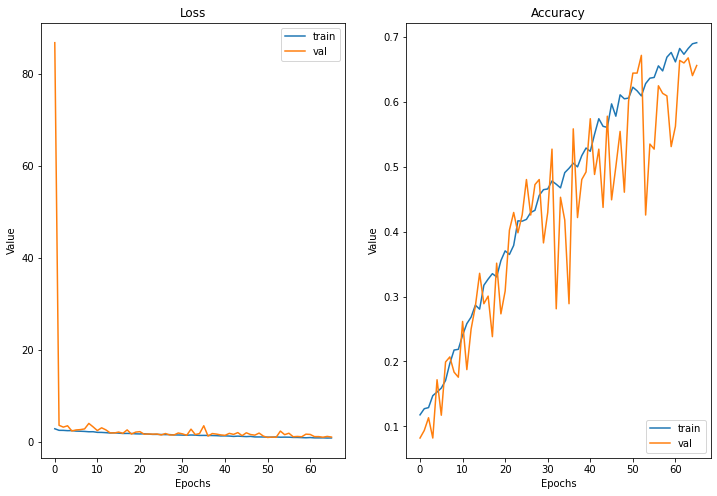

[[8.]
 [9.]
 [8.]
 [2.]
 [2.]
 [5.]
 [7.]
 [7.]
 [2.]
 [1.]
 [4.]
 [6.]
 [6.]
 [2.]
 [7.]
 [9.]
 [7.]
 [2.]
 [5.]
 [6.]
 [4.]
 [2.]
 [5.]
 [2.]
 [2.]
 [2.]
 [8.]
 [6.]
 [0.]
 [5.]
 [8.]
 [7.]
 [0.]
 [8.]
 [7.]
 [2.]
 [3.]
 [0.]
 [5.]
 [8.]
 [8.]
 [5.]
 [9.]
 [1.]
 [7.]
 [2.]
 [1.]
 [0.]
 [0.]
 [7.]
 [2.]
 [0.]
 [5.]
 [5.]
 [2.]
 [7.]
 [7.]
 [3.]
 [0.]
 [7.]
 [2.]
 [0.]
 [8.]
 [3.]
 [0.]
 [5.]
 [2.]
 [4.]
 [2.]
 [0.]
 [5.]
 [9.]
 [9.]
 [9.]
 [9.]
 [7.]
 [6.]
 [3.]
 [8.]
 [8.]
 [1.]
 [7.]
 [4.]
 [5.]
 [8.]
 [2.]
 [1.]
 [1.]
 [8.]
 [6.]
 [4.]
 [1.]
 [5.]
 [5.]
 [3.]
 [7.]
 [5.]
 [8.]
 [0.]
 [4.]
 [3.]
 [5.]
 [3.]
 [1.]
 [9.]
 [4.]
 [3.]
 [3.]
 [8.]
 [7.]
 [2.]
 [2.]
 [7.]
 [9.]
 [6.]
 [9.]
 [3.]
 [8.]
 [5.]
 [6.]
 [5.]
 [2.]
 [5.]
 [7.]
 [7.]
 [0.]
 [0.]
 [4.]
 [4.]
 [2.]
 [3.]
 [3.]
 [1.]
 [9.]
 [2.]
 [2.]
 [0.]
 [2.]
 [4.]
 [8.]
 [2.]
 [6.]
 [1.]
 [2.]
 [9.]
 [1.]
 [5.]
 [3.]
 [6.]
 [9.]
 [2.]
 [2.]
 [2.]
 [0.]
 [3.]
 [7.]
 [2.]
 [5.]
 [2.]
 [6.]
 [1.]
 [1.]
 [3.]
 [8.]
 [8.]
 [5.]
 [2.

Epoch 23/300
55/56 [============================>.] - ETA: 0s - loss: 1.8958 - accuracy: 0.3494
Epoch 00023: val_loss improved from 1.75074 to 1.54905, saving model to model1_best_0.h5
56/56 [==============================] - 2s 34ms/step - loss: 1.8995 - accuracy: 0.3493 - val_loss: 1.5490 - val_accuracy: 0.4570 - lr: 8.0000e-04
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 1.9444 - accuracy: 0.3375
Epoch 00024: val_loss did not improve from 1.54905
56/56 [==============================] - 1s 24ms/step - loss: 1.9478 - accuracy: 0.3371 - val_loss: 3.4919 - val_accuracy: 0.2539 - lr: 8.0000e-04
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.9440 - accuracy: 0.3375
Epoch 00025: val_loss did not improve from 1.54905
56/56 [==============================] - 1s 24ms/step - loss: 1.9413 - accuracy: 0.3365 - val_loss: 27.8813 - val_accuracy: 0.1172 - lr: 8.0000e-04
Epoch 26/300
56/56 [==============================] - ETA: 0s - loss: 1.9385 - 

Epoch 51/300
56/56 [==============================] - ETA: 0s - loss: 1.2445 - accuracy: 0.5731
Epoch 00051: val_loss did not improve from 1.26276
56/56 [==============================] - 1s 25ms/step - loss: 1.2445 - accuracy: 0.5731 - val_loss: 1.6798 - val_accuracy: 0.5625 - lr: 4.0960e-04
Epoch 52/300
54/56 [===========================>..] - ETA: 0s - loss: 1.3111 - accuracy: 0.5579
Epoch 00052: val_loss did not improve from 1.26276
56/56 [==============================] - 1s 24ms/step - loss: 1.3063 - accuracy: 0.5564 - val_loss: 2.1710 - val_accuracy: 0.5742 - lr: 4.0960e-04
Epoch 53/300
54/56 [===========================>..] - ETA: 0s - loss: 1.1955 - accuracy: 0.5891
Epoch 00053: val_loss did not improve from 1.26276
56/56 [==============================] - 1s 24ms/step - loss: 1.1930 - accuracy: 0.5882 - val_loss: 1.3430 - val_accuracy: 0.6328 - lr: 3.2768e-04
Epoch 54/300
56/56 [==============================] - ETA: 0s - loss: 1.1800 - accuracy: 0.5898
Epoch 00054: val_loss 

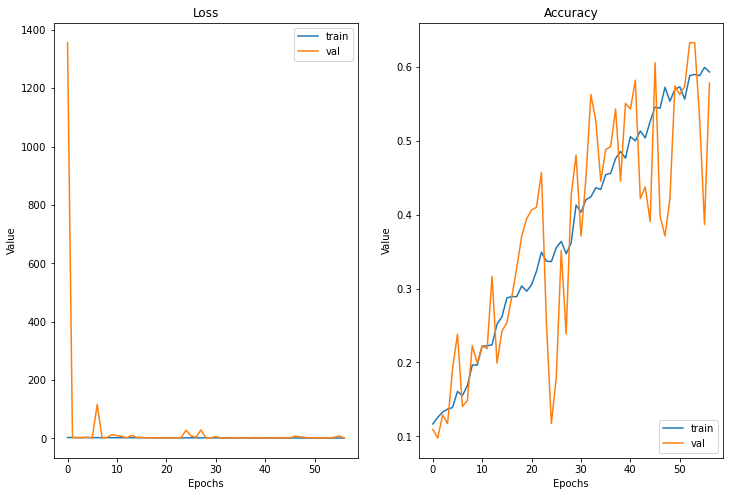

[[4.]
 [0.]
 [4.]
 [5.]
 [9.]
 [8.]
 [6.]
 [4.]
 [0.]
 [9.]
 [7.]
 [0.]
 [6.]
 [6.]
 [8.]
 [2.]
 [9.]
 [4.]
 [0.]
 [9.]
 [8.]
 [0.]
 [1.]
 [3.]
 [9.]
 [3.]
 [7.]
 [7.]
 [0.]
 [0.]
 [5.]
 [3.]
 [3.]
 [4.]
 [8.]
 [3.]
 [6.]
 [8.]
 [8.]
 [0.]
 [4.]
 [1.]
 [9.]
 [2.]
 [4.]
 [2.]
 [1.]
 [9.]
 [3.]
 [7.]
 [5.]
 [1.]
 [1.]
 [0.]
 [8.]
 [1.]
 [4.]
 [5.]
 [5.]
 [6.]
 [0.]
 [4.]
 [7.]
 [6.]
 [9.]
 [0.]
 [0.]
 [5.]
 [2.]
 [9.]
 [2.]
 [6.]
 [5.]
 [2.]
 [1.]
 [5.]
 [6.]
 [4.]
 [6.]
 [5.]
 [9.]
 [3.]
 [5.]
 [5.]
 [9.]
 [4.]
 [4.]
 [5.]
 [4.]
 [3.]
 [3.]
 [3.]
 [4.]
 [3.]
 [3.]
 [8.]
 [7.]
 [3.]
 [9.]
 [9.]
 [4.]
 [5.]
 [8.]
 [4.]
 [6.]
 [4.]
 [0.]
 [0.]
 [1.]
 [3.]
 [3.]
 [5.]
 [7.]
 [3.]
 [5.]
 [1.]
 [0.]
 [4.]
 [4.]
 [8.]
 [7.]
 [0.]
 [0.]
 [5.]
 [1.]
 [1.]
 [0.]
 [9.]
 [4.]
 [1.]
 [5.]
 [2.]
 [3.]
 [8.]
 [1.]
 [3.]
 [9.]
 [4.]
 [4.]
 [4.]
 [9.]
 [3.]
 [0.]
 [4.]
 [0.]
 [8.]
 [2.]
 [6.]
 [9.]
 [1.]
 [0.]
 [9.]
 [6.]
 [4.]
 [4.]
 [8.]
 [9.]
 [4.]
 [8.]
 [4.]
 [3.]
 [9.]
 [0.]
 [5.]
 [2.]
 [5.]
 [5.

Epoch 23/300
54/56 [===========================>..] - ETA: 0s - loss: 1.7388 - accuracy: 0.3981
Epoch 00023: val_loss did not improve from 1.56629
56/56 [==============================] - 1s 25ms/step - loss: 1.7432 - accuracy: 0.3973 - val_loss: 1.6335 - val_accuracy: 0.4258 - lr: 0.0010
Epoch 24/300
56/56 [==============================] - ETA: 0s - loss: 1.6517 - accuracy: 0.4152
Epoch 00024: val_loss did not improve from 1.56629
56/56 [==============================] - 1s 24ms/step - loss: 1.6517 - accuracy: 0.4152 - val_loss: 1.9933 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.6488 - accuracy: 0.4227
Epoch 00025: val_loss did not improve from 1.56629
56/56 [==============================] - 1s 24ms/step - loss: 1.6519 - accuracy: 0.4230 - val_loss: 2.0284 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 26/300
54/56 [===========================>..] - ETA: 0s - loss: 1.6920 - accuracy: 0.4115
Epoch 00026: val_loss did not impr

55/56 [============================>.] - ETA: 0s - loss: 1.1477 - accuracy: 0.5960
Epoch 00050: val_loss did not improve from 0.98206
56/56 [==============================] - 1s 23ms/step - loss: 1.1535 - accuracy: 0.5938 - val_loss: 1.4158 - val_accuracy: 0.5820 - lr: 4.0960e-04
Epoch 51/300
55/56 [============================>.] - ETA: 0s - loss: 1.1488 - accuracy: 0.5955
Epoch 00051: val_loss did not improve from 0.98206
56/56 [==============================] - 1s 23ms/step - loss: 1.1460 - accuracy: 0.5971 - val_loss: 1.4158 - val_accuracy: 0.5859 - lr: 4.0960e-04
Epoch 52/300
55/56 [============================>.] - ETA: 0s - loss: 1.0959 - accuracy: 0.6222
Epoch 00052: val_loss did not improve from 0.98206
56/56 [==============================] - 1s 23ms/step - loss: 1.1001 - accuracy: 0.6189 - val_loss: 1.1272 - val_accuracy: 0.6445 - lr: 4.0960e-04
Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 1.1112 - accuracy: 0.6216
Epoch 00053: val_loss did not impro

55/56 [============================>.] - ETA: 0s - loss: 0.8405 - accuracy: 0.7068
Epoch 00077: val_loss did not improve from 0.68133
56/56 [==============================] - 1s 23ms/step - loss: 0.8415 - accuracy: 0.7076 - val_loss: 0.9933 - val_accuracy: 0.7188 - lr: 1.6777e-04
Epoch 78/300
55/56 [============================>.] - ETA: 0s - loss: 0.8033 - accuracy: 0.7261
Epoch 00078: val_loss did not improve from 0.68133
56/56 [==============================] - 1s 23ms/step - loss: 0.7990 - accuracy: 0.7277 - val_loss: 0.7744 - val_accuracy: 0.7695 - lr: 1.6777e-04
Epoch 79/300
55/56 [============================>.] - ETA: 0s - loss: 0.8076 - accuracy: 0.7125
Epoch 00079: val_loss did not improve from 0.68133
56/56 [==============================] - 1s 23ms/step - loss: 0.8050 - accuracy: 0.7132 - val_loss: 0.8311 - val_accuracy: 0.7461 - lr: 1.6777e-04
Epoch 80/300
55/56 [============================>.] - ETA: 0s - loss: 0.8227 - accuracy: 0.7188
Epoch 00080: val_loss did not impro

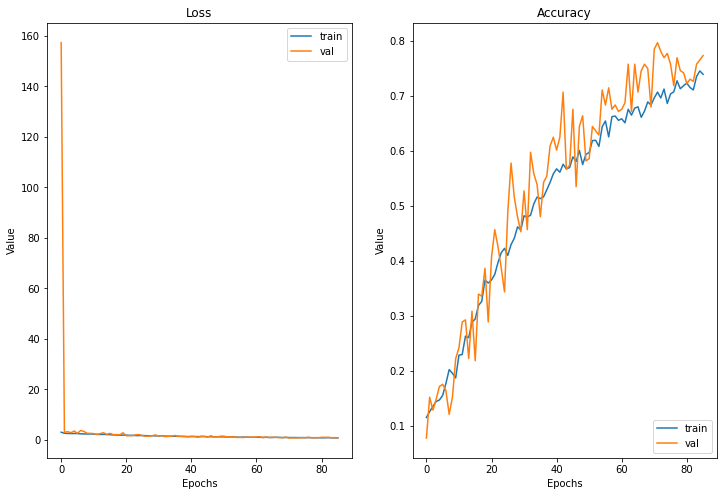

[[8.]
 [3.]
 [6.]
 [5.]
 [5.]
 [1.]
 [6.]
 [0.]
 [5.]
 [7.]
 [5.]
 [3.]
 [8.]
 [8.]
 [7.]
 [5.]
 [0.]
 [3.]
 [2.]
 [6.]
 [5.]
 [7.]
 [4.]
 [5.]
 [9.]
 [9.]
 [2.]
 [3.]
 [6.]
 [4.]
 [6.]
 [7.]
 [2.]
 [9.]
 [9.]
 [2.]
 [2.]
 [6.]
 [2.]
 [6.]
 [3.]
 [1.]
 [1.]
 [5.]
 [9.]
 [5.]
 [2.]
 [1.]
 [9.]
 [1.]
 [4.]
 [5.]
 [2.]
 [8.]
 [7.]
 [2.]
 [8.]
 [0.]
 [4.]
 [3.]
 [2.]
 [1.]
 [7.]
 [8.]
 [6.]
 [4.]
 [9.]
 [9.]
 [7.]
 [4.]
 [0.]
 [6.]
 [7.]
 [9.]
 [7.]
 [5.]
 [2.]
 [4.]
 [5.]
 [2.]
 [1.]
 [6.]
 [5.]
 [3.]
 [2.]
 [1.]
 [2.]
 [1.]
 [6.]
 [6.]
 [6.]
 [7.]
 [3.]
 [0.]
 [6.]
 [6.]
 [2.]
 [6.]
 [4.]
 [1.]
 [5.]
 [7.]
 [2.]
 [0.]
 [7.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [5.]
 [5.]
 [2.]
 [7.]
 [8.]
 [4.]
 [7.]
 [2.]
 [9.]
 [5.]
 [5.]
 [5.]
 [9.]
 [9.]
 [7.]
 [0.]
 [7.]
 [0.]
 [9.]
 [0.]
 [9.]
 [5.]
 [2.]
 [7.]
 [0.]
 [5.]
 [6.]
 [1.]
 [2.]
 [1.]
 [8.]
 [4.]
 [5.]
 [1.]
 [4.]
 [8.]
 [3.]
 [4.]
 [5.]
 [7.]
 [0.]
 [0.]
 [0.]
 [6.]
 [7.]
 [9.]
 [8.]
 [2.]
 [5.]
 [7.]
 [7.]
 [2.]
 [0.]
 [7.]
 [0.

56/56 [==============================] - 2s 33ms/step - loss: 1.7552 - accuracy: 0.3627 - val_loss: 1.6566 - val_accuracy: 0.4062 - lr: 6.4000e-04
Epoch 23/300
54/56 [===========================>..] - ETA: 0s - loss: 1.7315 - accuracy: 0.3785
Epoch 00023: val_loss improved from 1.65659 to 1.55909, saving model to model1_best_0.h5
56/56 [==============================] - 2s 33ms/step - loss: 1.7369 - accuracy: 0.3778 - val_loss: 1.5591 - val_accuracy: 0.4297 - lr: 6.4000e-04
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 1.7331 - accuracy: 0.4006 ETA: 0s - loss: 1.6
Epoch 00024: val_loss did not improve from 1.55909
56/56 [==============================] - 1s 23ms/step - loss: 1.7390 - accuracy: 0.3979 - val_loss: 1.9534 - val_accuracy: 0.3555 - lr: 6.4000e-04
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.6397 - accuracy: 0.4176
Epoch 00025: val_loss did not improve from 1.55909
56/56 [==============================] - 1s 23ms/step - loss

Epoch 50/300
55/56 [============================>.] - ETA: 0s - loss: 1.1653 - accuracy: 0.5949
Epoch 00050: val_loss did not improve from 1.21885
56/56 [==============================] - 1s 24ms/step - loss: 1.1646 - accuracy: 0.5949 - val_loss: 1.6755 - val_accuracy: 0.5586 - lr: 4.0960e-04
Epoch 51/300
56/56 [==============================] - ETA: 0s - loss: 1.1171 - accuracy: 0.6144
Epoch 00051: val_loss did not improve from 1.21885
56/56 [==============================] - 1s 24ms/step - loss: 1.1171 - accuracy: 0.6144 - val_loss: 1.7806 - val_accuracy: 0.4609 - lr: 4.0960e-04
Epoch 52/300
55/56 [============================>.] - ETA: 0s - loss: 1.0989 - accuracy: 0.6136
Epoch 00052: val_loss did not improve from 1.21885
56/56 [==============================] - 1s 24ms/step - loss: 1.0991 - accuracy: 0.6138 - val_loss: 1.3116 - val_accuracy: 0.6094 - lr: 3.2768e-04
Epoch 53/300
54/56 [===========================>..] - ETA: 0s - loss: 1.0469 - accuracy: 0.6412
Epoch 00053: val_loss 

Epoch 78/300
56/56 [==============================] - ETA: 0s - loss: 0.8073 - accuracy: 0.7221
Epoch 00078: val_loss did not improve from 0.90533
56/56 [==============================] - 1s 24ms/step - loss: 0.8073 - accuracy: 0.7221 - val_loss: 1.1949 - val_accuracy: 0.6602 - lr: 1.6777e-04
Epoch 79/300
55/56 [============================>.] - ETA: 0s - loss: 0.8389 - accuracy: 0.7165
Epoch 00079: val_loss did not improve from 0.90533
56/56 [==============================] - 1s 23ms/step - loss: 0.8373 - accuracy: 0.7160 - val_loss: 0.9622 - val_accuracy: 0.6797 - lr: 1.6777e-04
Epoch 80/300
55/56 [============================>.] - ETA: 0s - loss: 0.8120 - accuracy: 0.7119
Epoch 00080: val_loss did not improve from 0.90533
56/56 [==============================] - 1s 23ms/step - loss: 0.8079 - accuracy: 0.7143 - val_loss: 1.2173 - val_accuracy: 0.6250 - lr: 1.6777e-04
Epoch 81/300
54/56 [===========================>..] - ETA: 0s - loss: 0.8054 - accuracy: 0.7159
Epoch 00081: val_loss 

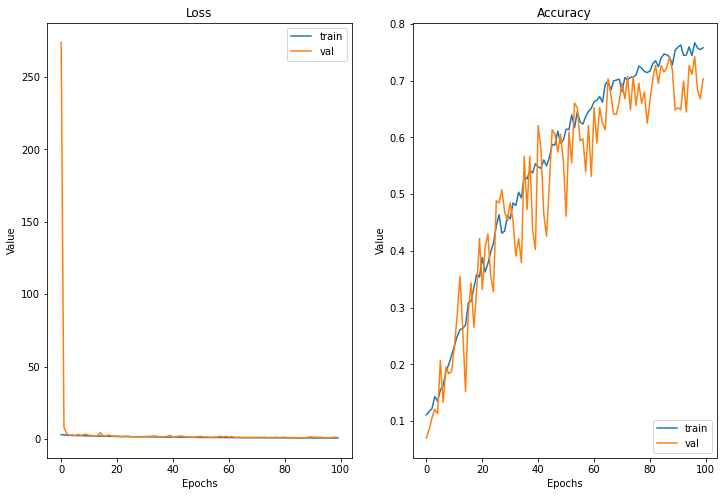

[[6.]
 [2.]
 [0.]
 [0.]
 [3.]
 [3.]
 [2.]
 [8.]
 [4.]
 [5.]
 [1.]
 [3.]
 [6.]
 [1.]
 [1.]
 [4.]
 [7.]
 [6.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [9.]
 [7.]
 [5.]
 [4.]
 [6.]
 [1.]
 [3.]
 [9.]
 [2.]
 [0.]
 [8.]
 [2.]
 [0.]
 [6.]
 [6.]
 [2.]
 [7.]
 [2.]
 [4.]
 [9.]
 [6.]
 [0.]
 [2.]
 [3.]
 [3.]
 [9.]
 [6.]
 [2.]
 [3.]
 [3.]
 [5.]
 [3.]
 [3.]
 [3.]
 [8.]
 [6.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [6.]
 [2.]
 [4.]
 [1.]
 [3.]
 [3.]
 [9.]
 [2.]
 [6.]
 [4.]
 [2.]
 [9.]
 [8.]
 [6.]
 [1.]
 [2.]
 [2.]
 [4.]
 [6.]
 [7.]
 [2.]
 [6.]
 [2.]
 [4.]
 [2.]
 [4.]
 [5.]
 [4.]
 [0.]
 [2.]
 [0.]
 [2.]
 [6.]
 [2.]
 [1.]
 [3.]
 [0.]
 [5.]
 [2.]
 [2.]
 [7.]
 [7.]
 [4.]
 [4.]
 [5.]
 [4.]
 [4.]
 [4.]
 [4.]
 [9.]
 [2.]
 [7.]
 [3.]
 [5.]
 [2.]
 [3.]
 [6.]
 [1.]
 [4.]
 [3.]
 [6.]
 [3.]
 [2.]
 [8.]
 [4.]
 [2.]
 [0.]
 [4.]
 [1.]
 [6.]
 [6.]
 [4.]
 [6.]
 [5.]
 [2.]
 [6.]
 [3.]
 [6.]
 [4.]
 [9.]
 [2.]
 [3.]
 [5.]
 [0.]
 [3.]
 [5.]
 [2.]
 [9.]
 [5.]
 [3.]
 [9.]
 [3.]
 [0.]
 [7.]
 [9.]
 [0.]
 [1.]
 [2.]
 [3.]
 [5.]
 [8.]
 [1.]
 [2.

Epoch 23/300
55/56 [============================>.] - ETA: 0s - loss: 1.7751 - accuracy: 0.3688
Epoch 00023: val_loss did not improve from 1.77423
56/56 [==============================] - 1s 23ms/step - loss: 1.7731 - accuracy: 0.3711 - val_loss: 1.8758 - val_accuracy: 0.4180 - lr: 0.0010
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 1.7590 - accuracy: 0.3949
Epoch 00024: val_loss improved from 1.77423 to 1.69302, saving model to model1_best_0.h5
56/56 [==============================] - 2s 33ms/step - loss: 1.7574 - accuracy: 0.3940 - val_loss: 1.6930 - val_accuracy: 0.4492 - lr: 0.0010
Epoch 25/300
54/56 [===========================>..] - ETA: 0s - loss: 1.6706 - accuracy: 0.4277
Epoch 00025: val_loss did not improve from 1.69302
56/56 [==============================] - 1s 23ms/step - loss: 1.6787 - accuracy: 0.4275 - val_loss: 1.9156 - val_accuracy: 0.3945 - lr: 0.0010
Epoch 26/300
55/56 [============================>.] - ETA: 0s - loss: 1.6709 - accuracy: 0.4

55/56 [============================>.] - ETA: 0s - loss: 1.0682 - accuracy: 0.6369
Epoch 00050: val_loss did not improve from 0.84324
56/56 [==============================] - 1s 23ms/step - loss: 1.0647 - accuracy: 0.6362 - val_loss: 1.0759 - val_accuracy: 0.6602 - lr: 6.4000e-04
Epoch 51/300
55/56 [============================>.] - ETA: 0s - loss: 1.0636 - accuracy: 0.6358
Epoch 00051: val_loss did not improve from 0.84324
56/56 [==============================] - 1s 23ms/step - loss: 1.0759 - accuracy: 0.6317 - val_loss: 1.2479 - val_accuracy: 0.6523 - lr: 6.4000e-04
Epoch 52/300
55/56 [============================>.] - ETA: 0s - loss: 1.0776 - accuracy: 0.6375
Epoch 00052: val_loss did not improve from 0.84324
56/56 [==============================] - 1s 23ms/step - loss: 1.0770 - accuracy: 0.6384 - val_loss: 1.2366 - val_accuracy: 0.6328 - lr: 6.4000e-04
Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 1.0602 - accuracy: 0.6295
Epoch 00053: val_loss did not impro

Epoch 78/300
55/56 [============================>.] - ETA: 0s - loss: 0.7346 - accuracy: 0.7415
Epoch 00078: val_loss did not improve from 0.57962
56/56 [==============================] - 1s 23ms/step - loss: 0.7362 - accuracy: 0.7422 - val_loss: 0.9347 - val_accuracy: 0.7266 - lr: 2.6214e-04
Epoch 79/300
54/56 [===========================>..] - ETA: 0s - loss: 0.7724 - accuracy: 0.7373
Epoch 00079: val_loss did not improve from 0.57962
56/56 [==============================] - 1s 23ms/step - loss: 0.7656 - accuracy: 0.7394 - val_loss: 0.8440 - val_accuracy: 0.7500 - lr: 2.6214e-04
Epoch 80/300
55/56 [============================>.] - ETA: 0s - loss: 0.7248 - accuracy: 0.7636
Epoch 00080: val_loss did not improve from 0.57962
56/56 [==============================] - 1s 23ms/step - loss: 0.7305 - accuracy: 0.7612 - val_loss: 0.7023 - val_accuracy: 0.7852 - lr: 2.6214e-04
Epoch 81/300
54/56 [===========================>..] - ETA: 0s - loss: 0.7248 - accuracy: 0.7529
Epoch 00081: val_loss 

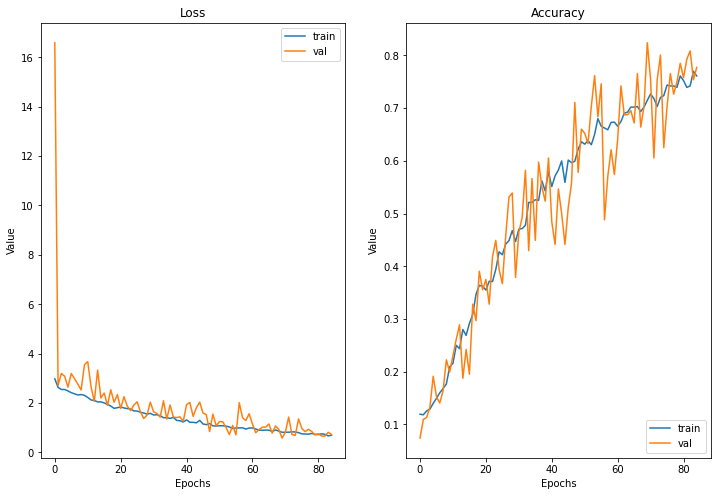

[[6.]
 [2.]
 [0.]
 [6.]
 [0.]
 [9.]
 [9.]
 [4.]
 [9.]
 [6.]
 [2.]
 [2.]
 [5.]
 [4.]
 [6.]
 [3.]
 [6.]
 [7.]
 [6.]
 [0.]
 [8.]
 [1.]
 [1.]
 [5.]
 [1.]
 [1.]
 [6.]
 [4.]
 [7.]
 [1.]
 [0.]
 [5.]
 [9.]
 [3.]
 [6.]
 [9.]
 [9.]
 [5.]
 [3.]
 [9.]
 [7.]
 [4.]
 [8.]
 [9.]
 [0.]
 [6.]
 [8.]
 [9.]
 [2.]
 [7.]
 [3.]
 [4.]
 [3.]
 [2.]
 [8.]
 [5.]
 [2.]
 [2.]
 [3.]
 [8.]
 [5.]
 [4.]
 [2.]
 [2.]
 [2.]
 [8.]
 [6.]
 [4.]
 [0.]
 [5.]
 [2.]
 [8.]
 [1.]
 [8.]
 [7.]
 [3.]
 [0.]
 [2.]
 [3.]
 [4.]
 [3.]
 [6.]
 [6.]
 [6.]
 [9.]
 [2.]
 [6.]
 [9.]
 [4.]
 [5.]
 [0.]
 [3.]
 [7.]
 [4.]
 [2.]
 [2.]
 [8.]
 [1.]
 [7.]
 [1.]
 [6.]
 [1.]
 [6.]
 [4.]
 [9.]
 [9.]
 [2.]
 [2.]
 [7.]
 [6.]
 [8.]
 [1.]
 [2.]
 [8.]
 [6.]
 [9.]
 [2.]
 [7.]
 [9.]
 [8.]
 [6.]
 [8.]
 [9.]
 [6.]
 [7.]
 [2.]
 [2.]
 [6.]
 [1.]
 [0.]
 [1.]
 [2.]
 [3.]
 [5.]
 [0.]
 [4.]
 [8.]
 [5.]
 [2.]
 [8.]
 [3.]
 [4.]
 [1.]
 [2.]
 [9.]
 [4.]
 [2.]
 [8.]
 [6.]
 [5.]
 [1.]
 [8.]
 [5.]
 [4.]
 [9.]
 [6.]
 [9.]
 [4.]
 [3.]
 [8.]
 [2.]
 [8.]
 [7.]
 [0.]
 [7.]
 [9.]
 [7.

Epoch 23/300
56/56 [==============================] - ETA: 0s - loss: 1.8471 - accuracy: 0.3538
Epoch 00023: val_loss did not improve from 1.91504
56/56 [==============================] - 1s 25ms/step - loss: 1.8471 - accuracy: 0.3538 - val_loss: 1.9491 - val_accuracy: 0.3984 - lr: 5.1200e-04
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 1.8486 - accuracy: 0.3506
Epoch 00024: val_loss did not improve from 1.91504
56/56 [==============================] - 1s 25ms/step - loss: 1.8474 - accuracy: 0.3504 - val_loss: 2.0622 - val_accuracy: 0.4531 - lr: 5.1200e-04
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.8362 - accuracy: 0.3562
Epoch 00025: val_loss did not improve from 1.91504
56/56 [==============================] - 1s 26ms/step - loss: 1.8299 - accuracy: 0.3566 - val_loss: 2.8095 - val_accuracy: 0.4297 - lr: 5.1200e-04
Epoch 26/300
55/56 [============================>.] - ETA: 0s - loss: 1.8051 - accuracy: 0.3744
Epoch 00026: val_loss 

Epoch 50/300
55/56 [============================>.] - ETA: 0s - loss: 1.3932 - accuracy: 0.5165
Epoch 00050: val_loss did not improve from 1.26850
56/56 [==============================] - 1s 24ms/step - loss: 1.3936 - accuracy: 0.5162 - val_loss: 1.5450 - val_accuracy: 0.5352 - lr: 3.2768e-04
Epoch 51/300
55/56 [============================>.] - ETA: 0s - loss: 1.3775 - accuracy: 0.5239
Epoch 00051: val_loss improved from 1.26850 to 1.20627, saving model to model1_best_0.h5
56/56 [==============================] - 2s 36ms/step - loss: 1.3772 - accuracy: 0.5251 - val_loss: 1.2063 - val_accuracy: 0.6094 - lr: 3.2768e-04
Epoch 52/300
56/56 [==============================] - ETA: 0s - loss: 1.3293 - accuracy: 0.5346
Epoch 00052: val_loss did not improve from 1.20627
56/56 [==============================] - 1s 25ms/step - loss: 1.3293 - accuracy: 0.5346 - val_loss: 1.2314 - val_accuracy: 0.5859 - lr: 3.2768e-04
Epoch 53/300
54/56 [===========================>..] - ETA: 0s - loss: 1.3968 - a

Epoch 78/300
55/56 [============================>.] - ETA: 0s - loss: 1.0094 - accuracy: 0.6483
Epoch 00078: val_loss did not improve from 0.97589
56/56 [==============================] - 1s 23ms/step - loss: 1.0069 - accuracy: 0.6490 - val_loss: 1.0576 - val_accuracy: 0.6562 - lr: 1.3422e-04
Epoch 79/300
55/56 [============================>.] - ETA: 0s - loss: 0.9758 - accuracy: 0.6597
Epoch 00079: val_loss did not improve from 0.97589
56/56 [==============================] - 1s 23ms/step - loss: 0.9774 - accuracy: 0.6596 - val_loss: 1.6197 - val_accuracy: 0.5625 - lr: 1.3422e-04
Epoch 80/300
55/56 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6557
Epoch 00080: val_loss did not improve from 0.97589
56/56 [==============================] - 1s 23ms/step - loss: 0.9844 - accuracy: 0.6562 - val_loss: 1.1886 - val_accuracy: 0.6523 - lr: 1.3422e-04
Epoch 00080: early stopping


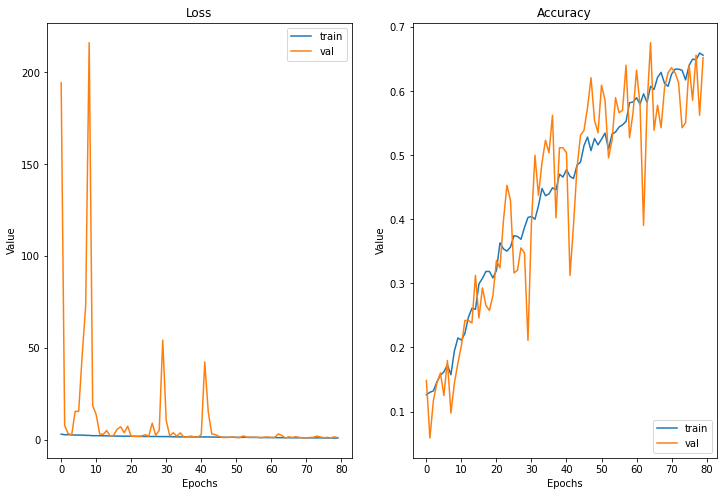

[[6.]
 [9.]
 [8.]
 [8.]
 [1.]
 [7.]
 [0.]
 [0.]
 [4.]
 [2.]
 [8.]
 [7.]
 [5.]
 [2.]
 [3.]
 [0.]
 [0.]
 [3.]
 [1.]
 [1.]
 [6.]
 [3.]
 [9.]
 [7.]
 [5.]
 [7.]
 [0.]
 [8.]
 [1.]
 [6.]
 [1.]
 [6.]
 [3.]
 [8.]
 [4.]
 [1.]
 [9.]
 [7.]
 [6.]
 [7.]
 [1.]
 [4.]
 [2.]
 [5.]
 [7.]
 [9.]
 [2.]
 [3.]
 [1.]
 [5.]
 [8.]
 [1.]
 [8.]
 [8.]
 [2.]
 [0.]
 [8.]
 [7.]
 [8.]
 [3.]
 [4.]
 [9.]
 [8.]
 [1.]
 [3.]
 [0.]
 [9.]
 [7.]
 [2.]
 [9.]
 [1.]
 [1.]
 [3.]
 [7.]
 [8.]
 [2.]
 [0.]
 [2.]
 [8.]
 [7.]
 [4.]
 [2.]
 [7.]
 [0.]
 [1.]
 [0.]
 [4.]
 [1.]
 [8.]
 [9.]
 [4.]
 [8.]
 [8.]
 [7.]
 [7.]
 [7.]
 [5.]
 [6.]
 [1.]
 [6.]
 [4.]
 [6.]
 [8.]
 [9.]
 [7.]
 [5.]
 [6.]
 [9.]
 [7.]
 [8.]
 [0.]
 [2.]
 [6.]
 [0.]
 [7.]
 [4.]
 [5.]
 [3.]
 [2.]
 [6.]
 [8.]
 [8.]
 [6.]
 [8.]
 [8.]
 [2.]
 [3.]
 [9.]
 [8.]
 [8.]
 [9.]
 [9.]
 [8.]
 [9.]
 [1.]
 [5.]
 [1.]
 [5.]
 [1.]
 [9.]
 [5.]
 [2.]
 [8.]
 [6.]
 [6.]
 [0.]
 [1.]
 [4.]
 [2.]
 [2.]
 [3.]
 [6.]
 [2.]
 [5.]
 [0.]
 [7.]
 [8.]
 [2.]
 [1.]
 [7.]
 [5.]
 [4.]
 [2.]
 [9.]
 [9.]
 [8.]
 [7.

Epoch 23/300
55/56 [============================>.] - ETA: 0s - loss: 1.7230 - accuracy: 0.4165
Epoch 00023: val_loss did not improve from 1.55668
56/56 [==============================] - 1s 23ms/step - loss: 1.7167 - accuracy: 0.4185 - val_loss: 2.0426 - val_accuracy: 0.4336 - lr: 8.0000e-04
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 1.6423 - accuracy: 0.4318
Epoch 00024: val_loss did not improve from 1.55668
56/56 [==============================] - 1s 23ms/step - loss: 1.6414 - accuracy: 0.4308 - val_loss: 1.6920 - val_accuracy: 0.4648 - lr: 8.0000e-04
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.6931 - accuracy: 0.4131
Epoch 00025: val_loss did not improve from 1.55668
56/56 [==============================] - 1s 23ms/step - loss: 1.6874 - accuracy: 0.4129 - val_loss: 1.8757 - val_accuracy: 0.3828 - lr: 8.0000e-04
Epoch 26/300
55/56 [============================>.] - ETA: 0s - loss: 1.5826 - accuracy: 0.4347
Epoch 00026: val_loss 

Epoch 51/300
55/56 [============================>.] - ETA: 0s - loss: 1.0605 - accuracy: 0.6330
Epoch 00051: val_loss did not improve from 1.08987
56/56 [==============================] - 1s 23ms/step - loss: 1.0643 - accuracy: 0.6306 - val_loss: 1.6687 - val_accuracy: 0.5742 - lr: 2.6214e-04
Epoch 52/300
55/56 [============================>.] - ETA: 0s - loss: 1.1330 - accuracy: 0.6097
Epoch 00052: val_loss did not improve from 1.08987
56/56 [==============================] - 1s 23ms/step - loss: 1.1327 - accuracy: 0.6088 - val_loss: 1.8979 - val_accuracy: 0.5039 - lr: 2.6214e-04
Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 1.0366 - accuracy: 0.6443
Epoch 00053: val_loss did not improve from 1.08987
56/56 [==============================] - 1s 23ms/step - loss: 1.0431 - accuracy: 0.6412 - val_loss: 1.3713 - val_accuracy: 0.6211 - lr: 2.6214e-04
Epoch 54/300
55/56 [============================>.] - ETA: 0s - loss: 1.0574 - accuracy: 0.6375
Epoch 00054: val_loss 

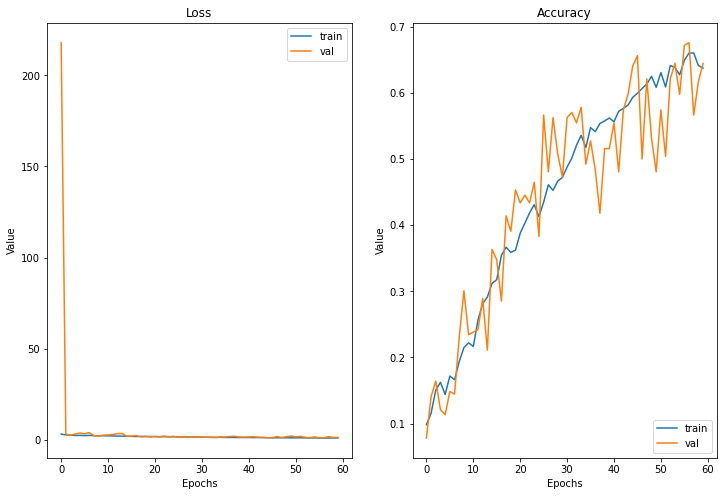

[[9.]
 [0.]
 [6.]
 [0.]
 [0.]
 [1.]
 [5.]
 [3.]
 [2.]
 [3.]
 [0.]
 [3.]
 [0.]
 [8.]
 [1.]
 [9.]
 [0.]
 [9.]
 [5.]
 [9.]
 [2.]
 [6.]
 [1.]
 [8.]
 [4.]
 [7.]
 [5.]
 [0.]
 [3.]
 [9.]
 [1.]
 [2.]
 [9.]
 [0.]
 [8.]
 [2.]
 [7.]
 [3.]
 [7.]
 [8.]
 [7.]
 [5.]
 [3.]
 [5.]
 [9.]
 [8.]
 [0.]
 [5.]
 [2.]
 [4.]
 [0.]
 [2.]
 [0.]
 [0.]
 [4.]
 [1.]
 [2.]
 [5.]
 [3.]
 [0.]
 [1.]
 [7.]
 [0.]
 [8.]
 [8.]
 [1.]
 [0.]
 [7.]
 [0.]
 [1.]
 [2.]
 [7.]
 [0.]
 [8.]
 [4.]
 [0.]
 [7.]
 [0.]
 [5.]
 [3.]
 [2.]
 [3.]
 [1.]
 [0.]
 [2.]
 [0.]
 [5.]
 [0.]
 [8.]
 [2.]
 [2.]
 [9.]
 [9.]
 [2.]
 [6.]
 [0.]
 [0.]
 [8.]
 [0.]
 [9.]
 [7.]
 [0.]
 [2.]
 [6.]
 [9.]
 [0.]
 [4.]
 [7.]
 [0.]
 [6.]
 [9.]
 [0.]
 [0.]
 [0.]
 [7.]
 [0.]
 [0.]
 [7.]
 [1.]
 [9.]
 [9.]
 [7.]
 [9.]
 [3.]
 [0.]
 [0.]
 [1.]
 [1.]
 [8.]
 [2.]
 [0.]
 [8.]
 [0.]
 [4.]
 [2.]
 [5.]
 [0.]
 [8.]
 [1.]
 [8.]
 [2.]
 [9.]
 [4.]
 [2.]
 [3.]
 [2.]
 [6.]
 [0.]
 [9.]
 [3.]
 [7.]
 [1.]
 [4.]
 [5.]
 [9.]
 [2.]
 [1.]
 [1.]
 [0.]
 [3.]
 [4.]
 [8.]
 [1.]
 [2.]
 [5.]
 [2.]
 [0.

Epoch 23/300
55/56 [============================>.] - ETA: 0s - loss: 2.0150 - accuracy: 0.3170
Epoch 00023: val_loss did not improve from 1.92830
56/56 [==============================] - 1s 23ms/step - loss: 2.0166 - accuracy: 0.3153 - val_loss: 16.3806 - val_accuracy: 0.2383 - lr: 8.0000e-04
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 2.0099 - accuracy: 0.3068
Epoch 00024: val_loss did not improve from 1.92830
56/56 [==============================] - 1s 23ms/step - loss: 2.0099 - accuracy: 0.3069 - val_loss: 17.6526 - val_accuracy: 0.1836 - lr: 8.0000e-04
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.8994 - accuracy: 0.3420
Epoch 00025: val_loss did not improve from 1.92830
56/56 [==============================] - 1s 23ms/step - loss: 1.8928 - accuracy: 0.3432 - val_loss: 13.1512 - val_accuracy: 0.2578 - lr: 8.0000e-04
Epoch 26/300
55/56 [============================>.] - ETA: 0s - loss: 1.8943 - accuracy: 0.3523
Epoch 00026: val_lo

55/56 [============================>.] - ETA: 0s - loss: 1.2719 - accuracy: 0.5540
Epoch 00050: val_loss did not improve from 1.20167
56/56 [==============================] - 1s 24ms/step - loss: 1.2698 - accuracy: 0.5564 - val_loss: 1.7308 - val_accuracy: 0.5664 - lr: 4.0960e-04
Epoch 51/300
55/56 [============================>.] - ETA: 0s - loss: 1.3352 - accuracy: 0.5307
Epoch 00051: val_loss did not improve from 1.20167
56/56 [==============================] - 1s 23ms/step - loss: 1.3360 - accuracy: 0.5307 - val_loss: 2.7014 - val_accuracy: 0.5039 - lr: 4.0960e-04
Epoch 52/300
55/56 [============================>.] - ETA: 0s - loss: 1.2745 - accuracy: 0.5636
Epoch 00052: val_loss did not improve from 1.20167
56/56 [==============================] - 1s 23ms/step - loss: 1.2719 - accuracy: 0.5653 - val_loss: 1.4365 - val_accuracy: 0.5742 - lr: 4.0960e-04
Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 1.2418 - accuracy: 0.5761
Epoch 00053: val_loss did not impro

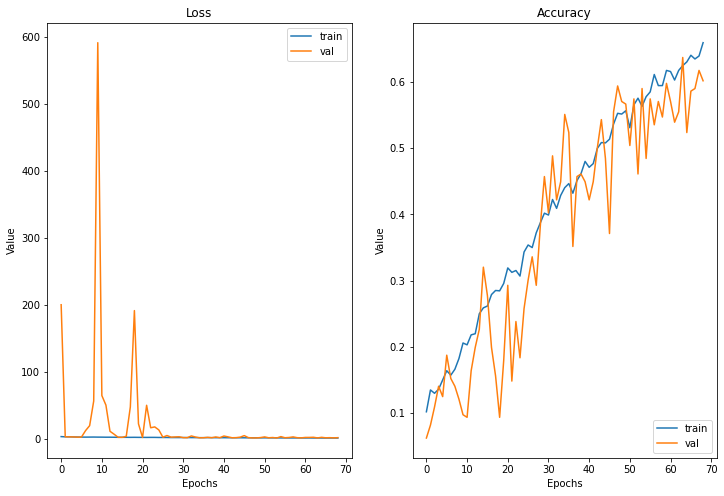

[[5.]
 [3.]
 [2.]
 [3.]
 [8.]
 [4.]
 [5.]
 [2.]
 [6.]
 [6.]
 [2.]
 [4.]
 [5.]
 [3.]
 [4.]
 [6.]
 [4.]
 [2.]
 [4.]
 [6.]
 [0.]
 [1.]
 [2.]
 [0.]
 [2.]
 [2.]
 [6.]
 [3.]
 [2.]
 [7.]
 [0.]
 [5.]
 [2.]
 [1.]
 [4.]
 [2.]
 [2.]
 [2.]
 [6.]
 [7.]
 [5.]
 [9.]
 [2.]
 [4.]
 [2.]
 [0.]
 [0.]
 [3.]
 [6.]
 [0.]
 [1.]
 [2.]
 [6.]
 [8.]
 [2.]
 [4.]
 [3.]
 [4.]
 [8.]
 [8.]
 [6.]
 [3.]
 [3.]
 [6.]
 [2.]
 [6.]
 [7.]
 [2.]
 [9.]
 [6.]
 [4.]
 [3.]
 [1.]
 [0.]
 [5.]
 [2.]
 [2.]
 [6.]
 [5.]
 [3.]
 [1.]
 [3.]
 [9.]
 [2.]
 [9.]
 [7.]
 [8.]
 [0.]
 [1.]
 [4.]
 [4.]
 [4.]
 [4.]
 [2.]
 [4.]
 [4.]
 [8.]
 [6.]
 [6.]
 [0.]
 [9.]
 [5.]
 [7.]
 [5.]
 [3.]
 [3.]
 [2.]
 [8.]
 [7.]
 [4.]
 [3.]
 [4.]
 [0.]
 [2.]
 [1.]
 [0.]
 [4.]
 [1.]
 [9.]
 [2.]
 [0.]
 [6.]
 [0.]
 [6.]
 [7.]
 [0.]
 [6.]
 [5.]
 [3.]
 [2.]
 [4.]
 [3.]
 [4.]
 [8.]
 [5.]
 [1.]
 [8.]
 [7.]
 [3.]
 [1.]
 [3.]
 [3.]
 [7.]
 [8.]
 [4.]
 [1.]
 [4.]
 [3.]
 [8.]
 [6.]
 [2.]
 [4.]
 [7.]
 [2.]
 [9.]
 [6.]
 [2.]
 [4.]
 [7.]
 [8.]
 [6.]
 [3.]
 [0.]
 [3.]
 [3.]
 [1.]
 [9.

In [12]:
RR_train, RR_test = get_stacking(DenseNet, X_trains, y_trains)

In [16]:
RR_train

array([[5],
       [6],
       [4],
       ...,
       [9],
       [0],
       [5]])

In [17]:
RR_test

array([[6],
       [9],
       [8],
       ...,
       [6],
       [3],
       [0]])

## Pickle 파일 저장

In [18]:
pickle.dump(RR_train, open("./pickle/RR_train.pkl", "wb"))
pickle.dump(RR_test, open("./pickle/RR_test.pkl", "wb"))